<a href="https://colab.research.google.com/github/cole-beach/MLB-Predictions/blob/main/MLB_OBP_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from seaborn import heatmap
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score

In [3]:
path = '/content/drive/MyDrive/Coding Dojo: Data Science/Portfolio/MLB Predictions/Data/Team_Batting_2010_2022.csv'
df = pd.read_csv(path)
df.head(5)

,Rk,Year,Tm,Lg,Wtm,Ltm,tmW-L%,#Bat,R/G,G,...,SLG,OPS,TB,GDP,HBP,SH,SF,IBB,LOB,OPS+
0,1,2019,HOU,AL,107,55,0.660,36,5.68,162,...,0.496,0.848,2781,146,66,10,57,17,1168,119
1,2,2010,NYY,AL,95,67,0.586,37,5.30,162,...,0.436,0.786,2427,124,73,33,44,36,1228,108
2,3,2020,ATL,NL,35,25,0.583,21,5.80,60,...,0.483,0.832,1001,39,23,1,7,13,446,117
3,4,2013,BOS,AL,97,65,0.599,38,5.27,162,...,0.446,0.795,2521,137,72,24,50,51,1212,116
4,5,2011,BOS,AL,90,72,0.556,36,5.40,162,...,0.461,0.810,2631,136,50,22,50,52,1190,116


In [4]:
df.columns

Index(['Rk', 'Year', 'Tm', 'Lg', 'Wtm', 'Ltm', 'tmW-L%', '#Bat', 'R/G', 'G',
       'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO',
       'BA', 'OBP', 'SLG', 'OPS', 'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB', 'LOB',
       'OPS+'],
      dtype='object')

In [5]:
df.rename(columns={"Rk": "Rank", "Tm": "Team", "Lg":'League', 'Wtm':'W', 'Ltm':'L'}, inplace=True)

In [6]:
df.shape

(300, 34)

In [7]:
df['Team'].value_counts()

LAD    13
COL    13
TBR    12
LAA    12
BOS    12
CLE    12
WSN    12
STL    12
NYY    11
CIN    11
MIN    11
NYM    11
MIL    11
TOR    10
TEX    10
OAK    10
CHC    10
ARI    10
ATL    10
BAL     9
HOU     9
SFG     9
CHW     9
PHI     9
KCR     8
DET     8
PIT     7
MIA     6
SEA     6
SDP     5
FLA     2
Name: Team, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rank    300 non-null    int64  
 1   Year    300 non-null    int64  
 2   Team    300 non-null    object 
 3   League  300 non-null    object 
 4   W       300 non-null    int64  
 5   L       300 non-null    int64  
 6   tmW-L%  300 non-null    float64
 7   #Bat    300 non-null    int64  
 8   R/G     300 non-null    float64
 9   G       300 non-null    int64  
 10  PA      300 non-null    int64  
 11  AB      300 non-null    int64  
 12  R       300 non-null    int64  
 13  H       300 non-null    int64  
 14  2B      300 non-null    int64  
 15  3B      300 non-null    int64  
 16  HR      300 non-null    int64  
 17  RBI     300 non-null    int64  
 18  SB      300 non-null    int64  
 19  CS      300 non-null    int64  
 20  BB      300 non-null    int64  
 21  SO      300 non-null    int64  
 22  BA

In [9]:
df.describe()

,Rank,Year,W,L,tmW-L%,#Bat,R/G,G,PA,AB,...,SLG,OPS,TB,GDP,HBP,SH,SF,IBB,LOB,OPS+
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000,300.000000,...,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,150.500000,2015.813333,76.003333,70.550000,0.520633,40.790000,4.554700,146.56000,5588.610000,4990.693333,...,0.415077,0.739157,2075.080000,110.600000,53.876667,34.350000,37.776667,30.383333,1011.170000,100.103333
std,86.746758,3.658292,22.877966,21.935315,0.071717,10.502073,0.423636,39.90247,1538.487118,1379.081801,...,0.025435,0.032165,588.786446,34.398705,19.569141,21.645846,12.897335,15.253588,281.176865,8.085206
min,1.000000,2010.000000,9.000000,6.000000,0.333000,13.000000,3.540000,22.00000,815.000000,716.000000,...,0.351000,0.666000,272.000000,12.000000,6.000000,0.000000,4.000000,0.000000,141.000000,81.000000
25%,75.750000,2013.000000,70.750000,66.000000,0.463000,37.000000,4.250000,162.00000,6087.000000,5436.750000,...,0.397750,0.716000,2137.500000,103.750000,42.000000,17.000000,34.000000,19.750000,1066.750000,94.000000
50%,150.500000,2016.000000,81.500000,74.000000,0.525000,42.000000,4.520000,162.00000,6154.500000,5512.000000,...,0.413000,0.736000,2256.500000,118.500000,53.000000,34.000000,40.000000,31.000000,1110.000000,99.000000
75%,225.250000,2019.000000,91.000000,85.000000,0.574000,48.000000,4.782500,162.00000,6233.000000,5565.000000,...,0.431250,0.759000,2362.000000,132.250000,66.000000,48.000000,45.000000,40.000000,1146.000000,105.000000
max,300.000000,2022.000000,108.000000,108.000000,0.750000,69.000000,5.820000,163.00000,6475.000000,5770.000000,...,0.496000,0.848000,2832.000000,169.000000,105.000000,89.000000,64.000000,78.000000,1257.000000,123.000000


In [10]:
df.isna().sum().any()

False

In [11]:
df.duplicated().any()

False

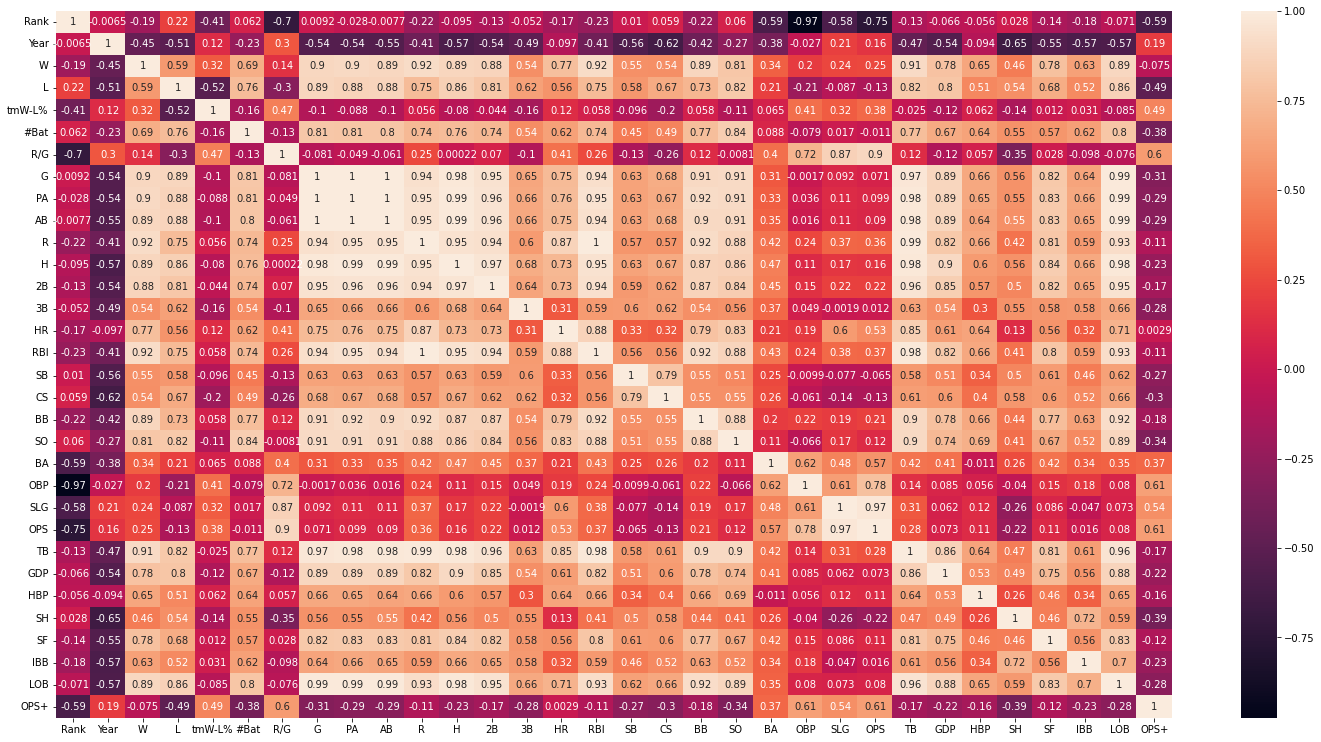

In [12]:
fig, ax = plt.subplots(figsize=(25,13))
sns.heatmap(df.corr(), annot=True, ax=ax);

In [13]:
# sns.pairplot(data=df, hue="Team", height=2.5)

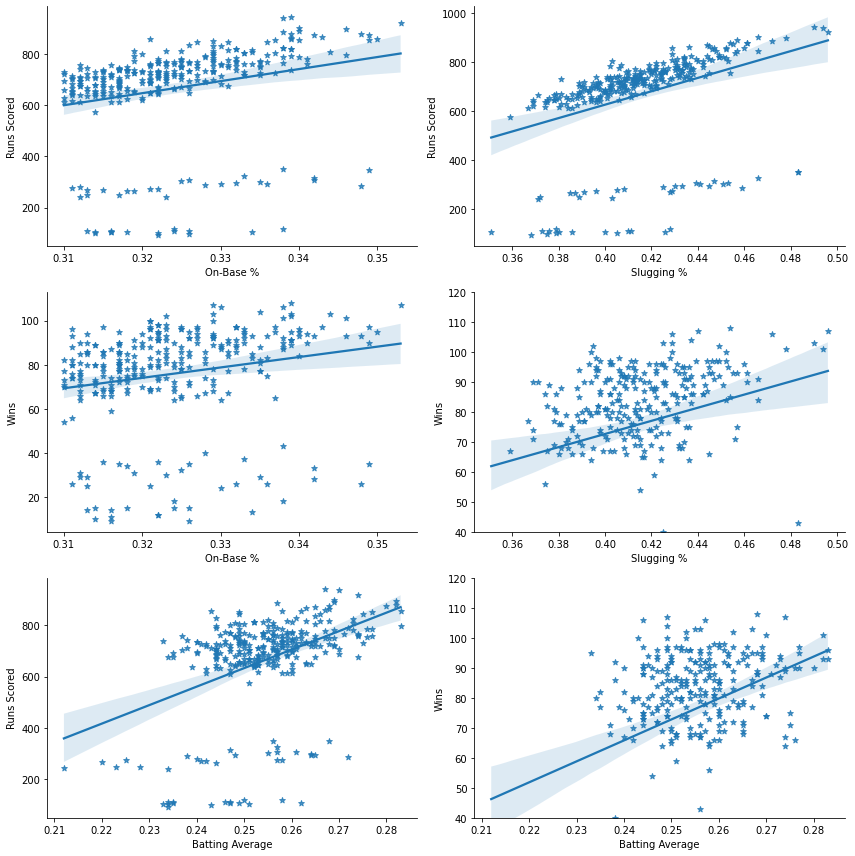

In [14]:
fig = plt.figure(figsize=(12,12))
#fig.suptitle("Offensive stats and its impact on Runs Scored and Wins")
ax1 = fig.add_subplot(3,2,1)
ax2 = fig.add_subplot(3,2,2)
ax3 = fig.add_subplot(3,2,3)
ax4 = fig.add_subplot(3,2,4)
ax5 = fig.add_subplot(3,2,5)
ax6 = fig.add_subplot(3,2,6)
sns.regplot(x="OBP", y="R", data=df, scatter=True, marker="*", ax=ax1)
sns.regplot(x="SLG", y="R", data=df, scatter=True, marker="*", ax=ax2)
sns.regplot(x="OBP", y="W", data=df, scatter=True, marker="*", ax=ax3)
sns.regplot(x="SLG", y="W", data=df, scatter=True, marker="*", ax=ax4)
sns.regplot(x="BA", y="R", data=df, scatter=True, marker="*", ax=ax5)
sns.regplot(x="BA", y="W", data=df, scatter=True, marker="*", ax=ax6)
ax1.set_xlabel("On-Base %")
ax1.set_ylabel("Runs Scored")
ax2.set_xlabel("Slugging %")
ax2.set_ylabel("Runs Scored")
ax3.set_xlabel("On-Base %")
ax3.set_ylabel("Wins")
ax4.set_xlabel("Slugging %")
ax4.set_ylabel("Wins")
ax5.set_xlabel("Batting Average")
ax5.set_ylabel("Runs Scored")
ax6.set_xlabel("Batting Average")
ax6.set_ylabel("Wins")
ax4.set_ylim([40,120])
ax6.set_ylim([40,120])
sns.despine()
plt.tight_layout()
plt.show()

In [15]:
obp_mean = df['OBP'].mean()

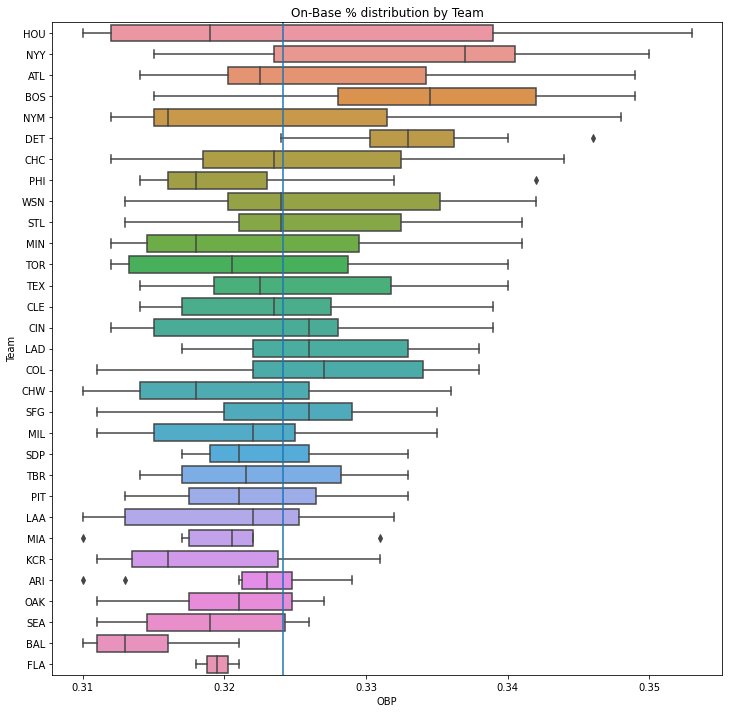

In [16]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(1,1,1)
sns.boxplot(x=df['OBP'], y=df['Team'], ax=ax)
plt.title("On-Base % distribution by Team")
plt.axvline(obp_mean)
plt.show()

In [17]:
df['League'] = df['League'].replace({'AL':0, 'NL':1})

In [18]:
X = df.drop(columns=['Team'])
y = df['Team']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.3, stratify = y)

In [19]:
# Instantiate Standard Scaler
num_selector = make_column_selector(dtype_include = 'number')
cat_selector = make_column_selector(dtype_include = 'object')

In [20]:
scaler = StandardScaler()
pca = PCA(n_components = .95)
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Take the mean of our numberical values, and most_frequent for categorical 
mean_imputer = SimpleImputer(strategy='mean')
freq_imputer = SimpleImputer(strategy='most_frequent')

In [21]:
num_processor = make_pipeline(mean_imputer, scaler)
cat_processor = make_pipeline(freq_imputer, ohe)

processing = make_pipeline(scaler, pca)

In [22]:
print('Shape before PCA:', X_train.shape)
print('Shape after PCA:', processing.fit_transform(X_train).shape)
print('Column count reduced by: ', X_train.shape[1] - processing.fit_transform(X_train).shape[1])

Shape before PCA: (90, 33)
Shape after PCA: (90, 9)
Column count reduced by:  24


In [23]:
num_tuple = (num_processor, num_selector)
cat_tuple = (cat_processor, cat_selector)

In [24]:
transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')

In [25]:
def eval_classification(model, X_train, X_test, y_train, y_test):
  print('Train Report:', classification_report(y_train, model.predict(X_train)))
  print('Test Report:', classification_report(y_test, model.predict(X_test)))

  cm = confusion_matrix(y_test, model.predict(X_test))

  plt.figure(figsize=(15, 15))
  sns.heatmap(cm, annot=True)
  plt.xlabel('Predicted', fontsize=40)
  plt.ylabel('True', fontsize=40)
  plt.show()

Train Report:               precision    recall  f1-score   support

         ARI       0.43      1.00      0.60         3
         ATL       0.22      0.67      0.33         3
         BAL       0.50      0.67      0.57         3
         BOS       0.44      1.00      0.62         4
         CHC       0.25      0.33      0.29         3
         CHW       0.18      0.67      0.29         3
         CIN       0.33      1.00      0.50         3
         CLE       0.17      0.25      0.20         4
         COL       1.00      1.00      1.00         4
         DET       1.00      1.00      1.00         2
         FLA       0.00      0.00      0.00         1
         HOU       0.00      0.00      0.00         3
         KCR       1.00      0.50      0.67         2
         LAA       0.20      0.25      0.22         4
         LAD       0.50      0.25      0.33         4
         MIA       0.00      0.00      0.00         2
         MIL       0.00      0.00      0.00         3
         MIN 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

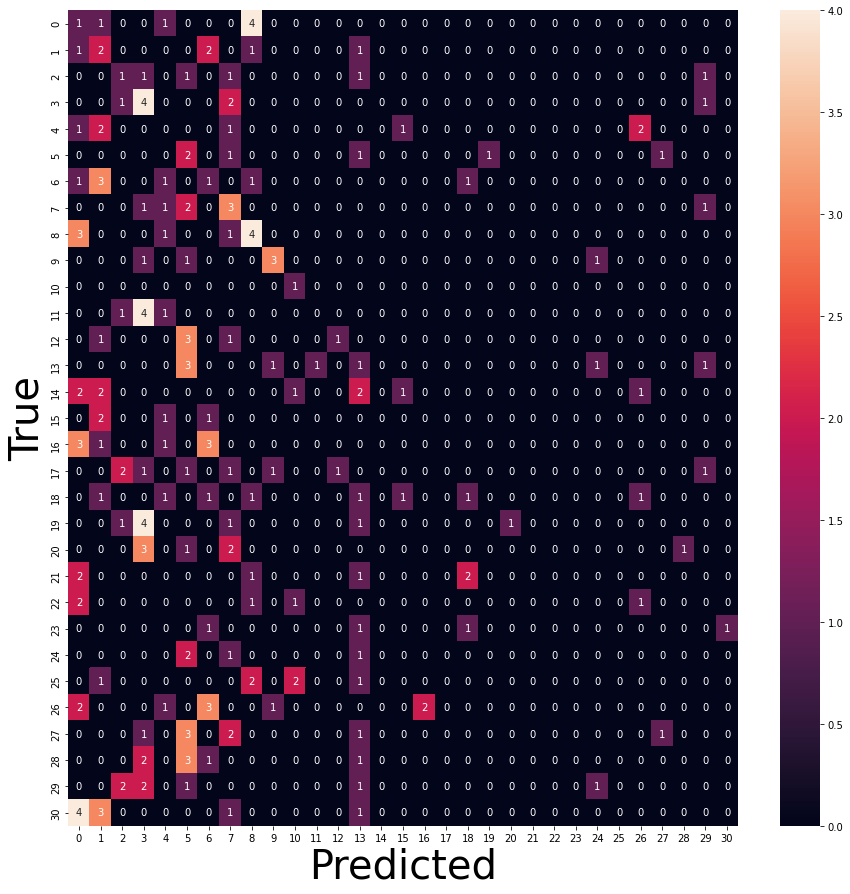

CPU times: user 2.61 s, sys: 218 ms, total: 2.83 s
Wall time: 2.95 s


In [26]:
%%time
knn = KNeighborsClassifier()
# Now we will build the pipeline
knn_pca_pipe = make_pipeline(scaler, pca, knn)

# fit the pipeline
knn_pca_pipe.fit(X_train, y_train)

eval_classification(knn_pca_pipe, X_train, X_test, y_train, y_test)

In [27]:
def plot_k_values(data, ks):
  sils = []
  inertias = []
  for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(data)
    sils.append(silhouette_score(data, km.labels_))
    inertias.append(km.inertia_)
      
  # plot inertia and silhouette score
  fig, ax1 = plt.subplots(figsize=(9,7))
  ax1.set_xlabel('number of clusters')
  ax1.set_ylabel('Inertia', color = 'blue')
  ax1.plot(ks, inertias, color = 'blue',label='inertia',marker ='o')

  
  ax2 = ax1.twinx() 
  
  ax2.set_ylabel('Silhouette Score', color = 'red')
  ax2.plot(ks, sils, color = 'red',label='silhouette score',marker='+')
  ax1.legend(loc=0)  
  ax2.legend(loc='upper left')
  plt.grid(True)
  plt.show()

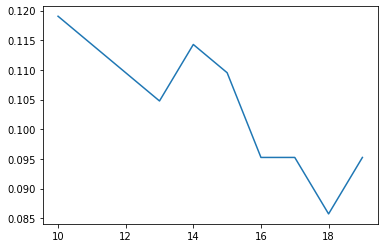

In [28]:
ks = range(10,20)

accuracies = []
for k in ks:
  knn = KNeighborsClassifier(n_neighbors = k)

  # Now we will build the pipeline
  knn_pca_pipe = make_pipeline(scaler, pca, knn)

  # fit the pipeline
  knn_pca_pipe.fit(X_train, y_train)

  accuracies.append(knn_pca_pipe.score(X_test, y_test))

plt.plot(ks, accuracies);